In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, MultiHeadAttention, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
#from tensorflow_addons.layers import MultiHeadAttention
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
import time
import wandb
from wandb.keras import WandbCallback
# Initialize wandb
wandb.init(project="Transferlearning1-FFT", entity="mamalik847")

totalMagnitude = 0
totalnumberofsamples = 0
def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)
        print(f"File extension detected: {self.file_extension}")  # Add this line


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)
    def process_data2(self, samples):
        # Convert samples list to a NumPy array and check the total number of samples
        samples_array = np.array(samples, dtype=np.complex64)
        total_samples = samples_array.size

        # Ensure that the total number of samples matches self.batch_size * self.sequence_length
        if total_samples != self.batch_size * self.sequence_length:
            # Handle this scenario: you might want to raise an error or handle it in some way
            raise ValueError("Total number of samples does not match batch_size * sequence_length")

        # Check for invalid values in samples_array before processing
        if np.isnan(samples_array).any() or np.isinf(samples_array).any():
            print(f"Invalid values found in samples_array: {samples_array}")
        # Reshape the samples array
        samples_array = samples_array.reshape(self.batch_size, self.sequence_length)
        #print('samples_array.shape:', samples_array.shape)

        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples_array)
        #print('samples_fft.shape:', samples_fft.shape)

        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)

#         # Normalize the real and imaginary parts
#         real_parts = (real_parts - np.mean(real_parts, axis=1, keepdims=True)) / np.std(real_parts, axis=1, keepdims=True)
#         imag_parts = (imag_parts - np.mean(imag_parts, axis=1, keepdims=True)) / np.std(imag_parts, axis=1, keepdims=True)
        
        # Normalize the real and imaginary parts
        epsilon = 1e-10
        real_parts_mean = np.mean(real_parts, axis=1, keepdims=True)
        real_parts_std = np.std(real_parts, axis=1, keepdims=True)
        real_parts_std[real_parts_std == 0] = epsilon  # Avoid division by zero
        real_parts = (real_parts - real_parts_mean) / real_parts_std

        imag_parts_mean = np.mean(imag_parts, axis=1, keepdims=True)
        imag_parts_std = np.std(imag_parts, axis=1, keepdims=True)
        imag_parts_std[imag_parts_std == 0] = epsilon  # Avoid division by zero
        imag_parts = (imag_parts - imag_parts_mean) / imag_parts_std

        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))

        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        return X

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable
        
        #if self.file_extension == '.dat':        
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break  # End of file
            decoded_data = struct.unpack('ff', binary_data)
            
            # Skip samples that are exactly zero (0 + 0j)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                continue

            # Convert the binary data to a complex number string
            decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n" if decoded_data[1] >= 0 else f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)

            # Check if we have enough samples for a batch
            if len(samples) == chunksize:
                X_chunk = self.process_data2(samples)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                # Clear samples for the next batch (optional, depends on your logic)
                samples = []

def plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path):
    for idx in range(0, len(all_X_chunk_test), sequence_length):
        sequence_idx = idx // sequence_length
        if all_intrusion_flags[sequence_idx]:
            plt.figure(figsize=(14, 6))
            time_steps = np.arange(idx * sequence_length, (idx + 1) * sequence_length)

            real_part_test = all_X_chunk_test[idx, :, 0].reshape(-1)
            imag_part_test = all_X_chunk_test[idx, :, 1].reshape(-1)
            real_part_pred = all_X_chunk_pred[idx, :, 0].reshape(-1)
            imag_part_pred = all_X_chunk_pred[idx, :, 1].reshape(-1)

            plt.plot(time_steps, real_part_test, 'b-', label='Original Real', linewidth=2)
            plt.plot(time_steps, real_part_pred, 'r--', label='Reconstructed Real', linewidth=2)
            plt.plot(time_steps, imag_part_test, 'g-', label='Original Imag', linewidth=2)
            plt.plot(time_steps, imag_part_pred, 'y--', label='Reconstructed Imag', linewidth=2)
            
            # Define where the fill should be applied (assuming the entire range for this example)
            where_fill = np.full_like(time_steps, True, dtype=bool)  # Fill the entire range
            plt.fill_between(time_steps, -3, 3, where=where_fill, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')

            #plt.fill_between(time_steps, -3, 3, where=True, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')
            
            # Enhancing font size and making bold
            plt.title(f'Original vs Reconstructed with Intrusion (Sequence {sequence_idx})', fontsize=18, fontweight='bold')
            plt.xlabel('Sample Index', fontsize=16, fontweight='bold')
            plt.ylabel('IQ Sample', fontsize=16, fontweight='bold')
            plt.legend(loc='lower right', fontsize=15)

            # Enhancing xtick and ytick labels
            for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
                label.set_fontsize(13)
                label.set_fontweight('bold')

            plt.tight_layout()

            filename = os.path.join(save_path, f'intrusion_sequence_{sequence_idx}.png')
            plt.savefig(filename)
            plt.close()

sequence_length = 10
#-------------------------------SelfAttention-RNN---------------------------------------
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)

model = Sequential()
# Input LSTM layer
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 8), return_sequences=True))  # Adjusted input_shape
# Self-attention layer
model.add(SelfAttentionLayer(num_heads=8, key_dim=100))
# Rest of the model remains the same
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(8)))  # Adjusted units in Dense layer

model.summary()
model.compile(optimizer='adam', loss='mse')
batch_size = 100

max_train_samples = 4000000  # I limit the train or can put None for whole data
train_steps = (max_train_samples) // (batch_size * sequence_length)
max_samples = 4000000  # Maximum samples to read (or None to read all)
max_test_samples = 4000000

# Example file patterns

num_pure_samples = count_lines('/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat')
print('num_pure_samples:', num_pure_samples)
pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'
# train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
#                                       max_samples, for_training=True)
# combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
#                                          max_test_samples, for_training=False)

train_gen_instance = DataGenerator(pure_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)
combined_gen_instance = DataGenerator(mixed_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)

num_epochs = 1  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        #loss = model.train_on_batch(X_chunk, Y_chunk)

        start_time = time.time() 
        loss = model.train_on_batch(X_chunk, Y_chunk)
        train_time = time.time() - start_time
        # Log batch training loss and training time
        wandb.log({"batch_loss": loss, "train_time_per_batch": train_time})
        
        if step % 200 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()
    
num_predictions = 2000  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")

#-------------------------Transfer Learning Part--------
# Define the smaller model for inference
# inference_model = Sequential()
# # Retain the encoder layers as is
# inference_model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 8), return_sequences=True))
# inference_model.add(SelfAttentionLayer(num_heads=8, key_dim=100))
# # Simplify the decoder
# inference_model.add(LSTM(50, activation='relu', return_sequences=False))
# inference_model.add(Dense(8))  # Final layer adjusted for your output requirements

# # Transfer weights for the retained parts from the original model
# # Before transferring weights, ensure each layer's compatibility
# original_model_layers = {layer.name: layer for layer in model.layers}
# for layer in inference_model.layers:
#     if layer.name in original_model_layers:
#         orig_layer = original_model_layers[layer.name]
#         # Check if the number of weights matches
#         if len(layer.get_weights()) == len(orig_layer.get_weights()):
#             layer.set_weights(orig_layer.get_weights())
#         else:
#             print(f"Skipped layer {layer.name} due to weight count mismatch.")
#     else:
#         print(f"Skipped layer {layer.name} as it has no corresponding layer in the original model.")


# # Ensure the inference model is compiled (if you plan on using methods like .evaluate() or .fit() on it)
# inference_model.compile(optimizer='adam', loss='mse')
#------------------second try-----------------------------------------------------
# Define input layer
input_shape = (sequence_length, 8)  # Adjust as per your input shape
inputs = Input(shape=input_shape)

# Encoder: Retain the encoder layers as is but with potentially simplified configurations
encoder_lstm = LSTM(64, activation='relu', return_sequences=True)(inputs)  # Reduced units

# Optional: Self-Attention layer if it's critical for your application
#self_attention = SelfAttentionLayer(num_heads=4, key_dim=64)(encoder_lstm)  # Optional and simplified

# Decoder: Simplify the decoder
decoder_lstm = LSTM(32, activation='relu', return_sequences=False)(encoder_lstm)  # Further reduced units
outputs = Dense(8)(decoder_lstm)  # Final layer adjusted for your output requirements

# Create the inference model
inference_model = Model(inputs, outputs)

# Transfer weights for the retained parts from the original model, focusing on compatible layers
for target_layer in inference_model.layers:
    for source_layer in model.layers:
        if target_layer.name == source_layer.name and len(target_layer.get_weights()) == len(source_layer.get_weights()):
            # Transfer weights
            target_layer.set_weights(source_layer.get_weights())

# Compile the inference model
inference_model.compile(optimizer='adam', loss='mse')

# Print model summaries for comparison
print("Original Model Summary:")
model.summary()
print("\nInference Model Summary:")
inference_model.summary()
# Now, use `inference_model` for predictions instead of the original `model`
# Prediction loop adapted for the inference model
print(f"Number of predictions to be performed: {num_predictions}")

reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
prediction_times = []


try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        start_time = time.time()
        X_chunk_test = next(combined_gen_instance)
        X_chunk_pred = inference_model.predict(X_chunk_test)  # Use inference_model here
        prediction_time = time.time() - start_time  # Calculate prediction time
        wandb.log({"prediction_time": prediction_time})
        prediction_times.append(prediction_time)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors.extend(chunk_errors)
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)
except StopIteration:
    print("All samples processed.")

#------------------------------------------------------------------------------------

# reconstruction_errors = []
# all_X_chunk_test = []
# all_X_chunk_pred = []
# all_intrusion_flags = []
# prediction_times = []
# try:
#     for _ in range(num_predictions):
#         print('prediction number:', _)
#         start_time = time.time()
#         X_chunk_test = next(combined_gen_instance)
#         X_chunk_pred = model.predict(X_chunk_test)
#         prediction_time = time.time() - start_time  # Calculate prediction time
#         wandb.log({"prediction_time": prediction_time})
#         prediction_times.append(prediction_time)
#         chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
#         reconstruction_errors.extend(chunk_errors)        
#         all_X_chunk_test.append(X_chunk_test)
#         all_X_chunk_pred.append(X_chunk_pred)
# except StopIteration:
#     print("All samples processed.")

reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())

#---------------------------------------111-----------------------------------
#max_error_per_sequence = reconstruction_error.reshape(-1, 8).max(axis=1)  # Shape (num_predictions * batch_size * sequence_length,)
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
print('max_error_per_sequence:', max_error_per_sequence)

#error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)  # Shape (num_predictions * batch_size,)
# Determine the threshold for intrusion
#threshold1 = np.percentile(error_per_sequence, 99.6)
threshold1 = np.percentile(max_error_per_sequence, 99.6)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

#is_intrusion_detected = error_per_sequence > threshold1  # Boolean array for sequences, shape (num_predictions * batch_size,)
is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)
#num_total_sequences = num_predictions * batch_size - num_predictions
num_total_sequences = len(max_error_per_sequence)
print('num_total_sequences:', num_total_sequences)
#---------------------------------------finish 111-----------------------------------
#flat_error_per_sequence = error_per_sequence.flatten()
flat_error_per_sequence = max_error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)
#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)
#---------------------------------------------------------------------------
#jamming_detected = reconstruction_error > threshold2
jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table to get insight
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")


2024-02-29 16:18:57.344142: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 16:18:57.345203: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 16:18:57.373277: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 16:18:57.373706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 16:18:57.811310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           43600     
                                                                 
 self_attention_layer (Self  (None, 10, 100)           322500    
 AttentionLayer)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 50)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 10, 100)           6

1/1 [==============================] - 0s 11ms/step
prediction number: 41
1/1 [==============================] - 0s 11ms/step
prediction number: 42
1/1 [==============================] - 0s 10ms/step
prediction number: 43
1/1 [==============================] - 0s 10ms/step
prediction number: 44
1/1 [==============================] - 0s 13ms/step
prediction number: 45
1/1 [==============================] - 0s 10ms/step
prediction number: 46
1/1 [==============================] - 0s 10ms/step
prediction number: 47
1/1 [==============================] - 0s 11ms/step
prediction number: 48
1/1 [==============================] - 0s 11ms/step
prediction number: 49
1/1 [==============================] - 0s 12ms/step
prediction number: 50
1/1 [==============================] - 0s 10ms/step
prediction number: 51
1/1 [==============================] - 0s 10ms/step
prediction number: 52
1/1 [==============================] - 0s 10ms/step
prediction number: 53
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step
prediction number: 151
1/1 [==============================] - 0s 10ms/step
prediction number: 152
1/1 [==============================] - 0s 10ms/step
prediction number: 153
1/1 [==============================] - 0s 11ms/step
prediction number: 154
1/1 [==============================] - 0s 10ms/step
prediction number: 155
1/1 [==============================] - 0s 10ms/step
prediction number: 156
1/1 [==============================] - 0s 10ms/step
prediction number: 157
1/1 [==============================] - 0s 10ms/step
prediction number: 158
1/1 [==============================] - 0s 11ms/step
prediction number: 159
1/1 [==============================] - 0s 11ms/step
prediction number: 160
1/1 [==============================] - 0s 11ms/step
prediction number: 161
1/1 [==============================] - 0s 11ms/step
prediction number: 162
1/1 [==============================] - 0s 11ms/step
prediction number: 163
1/1 [====================

1/1 [==============================] - 0s 10ms/step
prediction number: 260
1/1 [==============================] - 0s 10ms/step
prediction number: 261
1/1 [==============================] - 0s 10ms/step
prediction number: 262
1/1 [==============================] - 0s 10ms/step
prediction number: 263
1/1 [==============================] - 0s 11ms/step
prediction number: 264
1/1 [==============================] - 0s 11ms/step
prediction number: 265
1/1 [==============================] - 0s 10ms/step
prediction number: 266
1/1 [==============================] - 0s 11ms/step
prediction number: 267
1/1 [==============================] - 0s 11ms/step
prediction number: 268
1/1 [==============================] - 0s 11ms/step
prediction number: 269
1/1 [==============================] - 0s 10ms/step
prediction number: 270
1/1 [==============================] - 0s 11ms/step
prediction number: 271
1/1 [==============================] - 0s 11ms/step
prediction number: 272
1/1 [====================

1/1 [==============================] - 0s 11ms/step
prediction number: 369
1/1 [==============================] - 0s 11ms/step
prediction number: 370
1/1 [==============================] - 0s 10ms/step
prediction number: 371
1/1 [==============================] - 0s 10ms/step
prediction number: 372
1/1 [==============================] - 0s 10ms/step
prediction number: 373
1/1 [==============================] - 0s 11ms/step
prediction number: 374
1/1 [==============================] - 0s 11ms/step
prediction number: 375
1/1 [==============================] - 0s 13ms/step
prediction number: 376
1/1 [==============================] - 0s 12ms/step
prediction number: 377
1/1 [==============================] - 0s 11ms/step
prediction number: 378
1/1 [==============================] - 0s 10ms/step
prediction number: 379
1/1 [==============================] - 0s 10ms/step
prediction number: 380
1/1 [==============================] - 0s 10ms/step
prediction number: 381
1/1 [====================

1/1 [==============================] - 0s 10ms/step
prediction number: 478
1/1 [==============================] - 0s 10ms/step
prediction number: 479
1/1 [==============================] - 0s 12ms/step
prediction number: 480
1/1 [==============================] - 0s 11ms/step
prediction number: 481
1/1 [==============================] - 0s 10ms/step
prediction number: 482
1/1 [==============================] - 0s 10ms/step
prediction number: 483
1/1 [==============================] - 0s 10ms/step
prediction number: 484
1/1 [==============================] - 0s 10ms/step
prediction number: 485
1/1 [==============================] - 0s 10ms/step
prediction number: 486
1/1 [==============================] - 0s 10ms/step
prediction number: 487
1/1 [==============================] - 0s 11ms/step
prediction number: 488
1/1 [==============================] - 0s 10ms/step
prediction number: 489
1/1 [==============================] - 0s 10ms/step
prediction number: 490
1/1 [====================

1/1 [==============================] - 0s 12ms/step
prediction number: 587
1/1 [==============================] - 0s 12ms/step
prediction number: 588
1/1 [==============================] - 0s 11ms/step
prediction number: 589
1/1 [==============================] - 0s 10ms/step
prediction number: 590
1/1 [==============================] - 0s 11ms/step
prediction number: 591
1/1 [==============================] - 0s 10ms/step
prediction number: 592
1/1 [==============================] - 0s 10ms/step
prediction number: 593
1/1 [==============================] - 0s 11ms/step
prediction number: 594
1/1 [==============================] - 0s 10ms/step
prediction number: 595
1/1 [==============================] - 0s 10ms/step
prediction number: 596
1/1 [==============================] - 0s 10ms/step
prediction number: 597
1/1 [==============================] - 0s 10ms/step
prediction number: 598
1/1 [==============================] - 0s 11ms/step
prediction number: 599
1/1 [====================

1/1 [==============================] - 0s 12ms/step
prediction number: 696
1/1 [==============================] - 0s 13ms/step
prediction number: 697
1/1 [==============================] - 0s 10ms/step
prediction number: 698
1/1 [==============================] - 0s 10ms/step
prediction number: 699
1/1 [==============================] - 0s 10ms/step
prediction number: 700
1/1 [==============================] - 0s 10ms/step
prediction number: 701
1/1 [==============================] - 0s 10ms/step
prediction number: 702
1/1 [==============================] - 0s 10ms/step
prediction number: 703
1/1 [==============================] - 0s 11ms/step
prediction number: 704
1/1 [==============================] - 0s 11ms/step
prediction number: 705
1/1 [==============================] - 0s 11ms/step
prediction number: 706
1/1 [==============================] - 0s 10ms/step
prediction number: 707
1/1 [==============================] - 0s 11ms/step
prediction number: 708
1/1 [====================

1/1 [==============================] - 0s 10ms/step
prediction number: 805
1/1 [==============================] - 0s 11ms/step
prediction number: 806
1/1 [==============================] - 0s 11ms/step
prediction number: 807
1/1 [==============================] - 0s 11ms/step
prediction number: 808
1/1 [==============================] - 0s 10ms/step
prediction number: 809
1/1 [==============================] - 0s 12ms/step
prediction number: 810
1/1 [==============================] - 0s 10ms/step
prediction number: 811
1/1 [==============================] - 0s 10ms/step
prediction number: 812
1/1 [==============================] - 0s 10ms/step
prediction number: 813
1/1 [==============================] - 0s 10ms/step
prediction number: 814
1/1 [==============================] - 0s 11ms/step
prediction number: 815
1/1 [==============================] - 0s 11ms/step
prediction number: 816
1/1 [==============================] - 0s 11ms/step
prediction number: 817
1/1 [====================

1/1 [==============================] - 0s 10ms/step
prediction number: 914
1/1 [==============================] - 0s 10ms/step
prediction number: 915
1/1 [==============================] - 0s 10ms/step
prediction number: 916
1/1 [==============================] - 0s 11ms/step
prediction number: 917
1/1 [==============================] - 0s 10ms/step
prediction number: 918
1/1 [==============================] - 0s 11ms/step
prediction number: 919
1/1 [==============================] - 0s 10ms/step
prediction number: 920
1/1 [==============================] - 0s 11ms/step
prediction number: 921
1/1 [==============================] - 0s 11ms/step
prediction number: 922
1/1 [==============================] - 0s 10ms/step
prediction number: 923
1/1 [==============================] - 0s 10ms/step
prediction number: 924
1/1 [==============================] - 0s 10ms/step
prediction number: 925
1/1 [==============================] - 0s 10ms/step
prediction number: 926
1/1 [====================

1/1 [==============================] - 0s 11ms/step
prediction number: 1023
1/1 [==============================] - 0s 10ms/step
prediction number: 1024
1/1 [==============================] - 0s 10ms/step
prediction number: 1025
1/1 [==============================] - 0s 11ms/step
prediction number: 1026
1/1 [==============================] - 0s 11ms/step
prediction number: 1027
1/1 [==============================] - 0s 10ms/step
prediction number: 1028
1/1 [==============================] - 0s 12ms/step
prediction number: 1029
1/1 [==============================] - 0s 11ms/step
prediction number: 1030
1/1 [==============================] - 0s 11ms/step
prediction number: 1031
1/1 [==============================] - 0s 11ms/step
prediction number: 1032
1/1 [==============================] - 0s 11ms/step
prediction number: 1033
1/1 [==============================] - 0s 11ms/step
prediction number: 1034
1/1 [==============================] - 0s 10ms/step
prediction number: 1035
1/1 [=======

1/1 [==============================] - 0s 10ms/step
prediction number: 1131
1/1 [==============================] - 0s 11ms/step
prediction number: 1132
1/1 [==============================] - 0s 10ms/step
prediction number: 1133
1/1 [==============================] - 0s 11ms/step
prediction number: 1134
1/1 [==============================] - 0s 11ms/step
prediction number: 1135
1/1 [==============================] - 0s 15ms/step
prediction number: 1136
1/1 [==============================] - 0s 12ms/step
prediction number: 1137
1/1 [==============================] - 0s 14ms/step
prediction number: 1138
1/1 [==============================] - 0s 14ms/step
prediction number: 1139
1/1 [==============================] - 0s 14ms/step
prediction number: 1140
1/1 [==============================] - 0s 13ms/step
prediction number: 1141
1/1 [==============================] - 0s 11ms/step
prediction number: 1142
1/1 [==============================] - 0s 14ms/step
prediction number: 1143
1/1 [=======

1/1 [==============================] - 0s 11ms/step
prediction number: 1239
1/1 [==============================] - 0s 11ms/step
prediction number: 1240
1/1 [==============================] - 0s 11ms/step
prediction number: 1241
1/1 [==============================] - 0s 12ms/step
prediction number: 1242
1/1 [==============================] - 0s 11ms/step
prediction number: 1243
1/1 [==============================] - 0s 11ms/step
prediction number: 1244
1/1 [==============================] - 0s 11ms/step
prediction number: 1245
1/1 [==============================] - 0s 11ms/step
prediction number: 1246
1/1 [==============================] - 0s 10ms/step
prediction number: 1247
1/1 [==============================] - 0s 10ms/step
prediction number: 1248
1/1 [==============================] - 0s 10ms/step
prediction number: 1249
1/1 [==============================] - 0s 10ms/step
prediction number: 1250
1/1 [==============================] - 0s 10ms/step
prediction number: 1251
1/1 [=======

1/1 [==============================] - 0s 13ms/step
prediction number: 1347
1/1 [==============================] - 0s 14ms/step
prediction number: 1348
1/1 [==============================] - 0s 14ms/step
prediction number: 1349
1/1 [==============================] - 0s 14ms/step
prediction number: 1350
1/1 [==============================] - 0s 13ms/step
prediction number: 1351
1/1 [==============================] - 0s 14ms/step
prediction number: 1352
1/1 [==============================] - 0s 13ms/step
prediction number: 1353
1/1 [==============================] - 0s 14ms/step
prediction number: 1354
1/1 [==============================] - 0s 14ms/step
prediction number: 1355
1/1 [==============================] - 0s 13ms/step
prediction number: 1356
1/1 [==============================] - 0s 14ms/step
prediction number: 1357
1/1 [==============================] - 0s 13ms/step
prediction number: 1358
1/1 [==============================] - 0s 13ms/step
prediction number: 1359
1/1 [=======

1/1 [==============================] - 0s 11ms/step
prediction number: 1455
1/1 [==============================] - 0s 10ms/step
prediction number: 1456
1/1 [==============================] - 0s 10ms/step
prediction number: 1457
1/1 [==============================] - 0s 11ms/step
prediction number: 1458
1/1 [==============================] - 0s 11ms/step
prediction number: 1459
1/1 [==============================] - 0s 11ms/step
prediction number: 1460
1/1 [==============================] - 0s 10ms/step
prediction number: 1461
1/1 [==============================] - 0s 11ms/step
prediction number: 1462
1/1 [==============================] - 0s 10ms/step
prediction number: 1463
1/1 [==============================] - 0s 10ms/step
prediction number: 1464
1/1 [==============================] - 0s 11ms/step
prediction number: 1465
1/1 [==============================] - 0s 11ms/step
prediction number: 1466
1/1 [==============================] - 0s 10ms/step
prediction number: 1467
1/1 [=======

1/1 [==============================] - 0s 11ms/step
prediction number: 1563
1/1 [==============================] - 0s 12ms/step
prediction number: 1564
1/1 [==============================] - 0s 14ms/step
prediction number: 1565
1/1 [==============================] - 0s 14ms/step
prediction number: 1566
1/1 [==============================] - 0s 14ms/step
prediction number: 1567
1/1 [==============================] - 0s 13ms/step
prediction number: 1568
1/1 [==============================] - 0s 13ms/step
prediction number: 1569
1/1 [==============================] - 0s 10ms/step
prediction number: 1570
1/1 [==============================] - 0s 11ms/step
prediction number: 1571
1/1 [==============================] - 0s 12ms/step
prediction number: 1572
1/1 [==============================] - 0s 12ms/step
prediction number: 1573
1/1 [==============================] - 0s 11ms/step
prediction number: 1574
1/1 [==============================] - 0s 11ms/step
prediction number: 1575
1/1 [=======

prediction number: 1670
1/1 [==============================] - 0s 11ms/step
prediction number: 1671
1/1 [==============================] - 0s 11ms/step
prediction number: 1672
1/1 [==============================] - 0s 11ms/step
prediction number: 1673
1/1 [==============================] - 0s 11ms/step
prediction number: 1674
1/1 [==============================] - 0s 11ms/step
prediction number: 1675
1/1 [==============================] - 0s 11ms/step
prediction number: 1676
1/1 [==============================] - 0s 11ms/step
prediction number: 1677
1/1 [==============================] - 0s 11ms/step
prediction number: 1678
1/1 [==============================] - 0s 11ms/step
prediction number: 1679
1/1 [==============================] - 0s 10ms/step
prediction number: 1680
1/1 [==============================] - 0s 11ms/step
prediction number: 1681
1/1 [==============================] - 0s 11ms/step
prediction number: 1682
1/1 [==============================] - 0s 11ms/step
prediction n

1/1 [==============================] - 0s 11ms/step
prediction number: 1778
1/1 [==============================] - 0s 12ms/step
prediction number: 1779
1/1 [==============================] - 0s 12ms/step
prediction number: 1780
1/1 [==============================] - 0s 12ms/step
prediction number: 1781
1/1 [==============================] - 0s 11ms/step
prediction number: 1782
1/1 [==============================] - 0s 11ms/step
prediction number: 1783
1/1 [==============================] - 0s 11ms/step
prediction number: 1784
1/1 [==============================] - 0s 12ms/step
prediction number: 1785
1/1 [==============================] - 0s 12ms/step
prediction number: 1786
1/1 [==============================] - 0s 12ms/step
prediction number: 1787
1/1 [==============================] - 0s 12ms/step
prediction number: 1788
1/1 [==============================] - 0s 12ms/step
prediction number: 1789
1/1 [==============================] - 0s 13ms/step
prediction number: 1790
1/1 [=======

1/1 [==============================] - 0s 13ms/step
prediction number: 1886
1/1 [==============================] - 0s 14ms/step
prediction number: 1887
1/1 [==============================] - 0s 14ms/step
prediction number: 1888
1/1 [==============================] - 0s 15ms/step
prediction number: 1889
1/1 [==============================] - 0s 17ms/step
prediction number: 1890
1/1 [==============================] - 0s 17ms/step
prediction number: 1891
1/1 [==============================] - 0s 17ms/step
prediction number: 1892
1/1 [==============================] - 0s 14ms/step
prediction number: 1893
1/1 [==============================] - 0s 14ms/step
prediction number: 1894
1/1 [==============================] - 0s 13ms/step
prediction number: 1895
1/1 [==============================] - 0s 13ms/step
prediction number: 1896
1/1 [==============================] - 0s 14ms/step
prediction number: 1897
1/1 [==============================] - 0s 16ms/step
prediction number: 1898
1/1 [=======

1/1 [==============================] - 0s 14ms/step
prediction number: 1994
1/1 [==============================] - 0s 12ms/step
prediction number: 1995
1/1 [==============================] - 0s 14ms/step
prediction number: 1996
1/1 [==============================] - 0s 14ms/step
prediction number: 1997
1/1 [==============================] - 0s 12ms/step
prediction number: 1998
1/1 [==============================] - 0s 14ms/step
prediction number: 1999
1/1 [==============================] - 0s 14ms/step
reconstruction_error.shape: (20000, 8)
Number of NaNs in reconstruction_error: 0
max_error_per_sequence: [ 9.70648826  8.93726106 11.04056469 ...  1.46520209  1.40704622
  0.99066246]
threshold1: 20.768619835491304
threshold percentile: 11.297141796939528
len(is_intrusion_detected): 20000
is_intrusion_detected.shape: (20000,)
num_total_sequences: 20000
        Part  True Count  False Count
0       Real           0        20000
1  Imaginary           0        20000
2    Overall          8

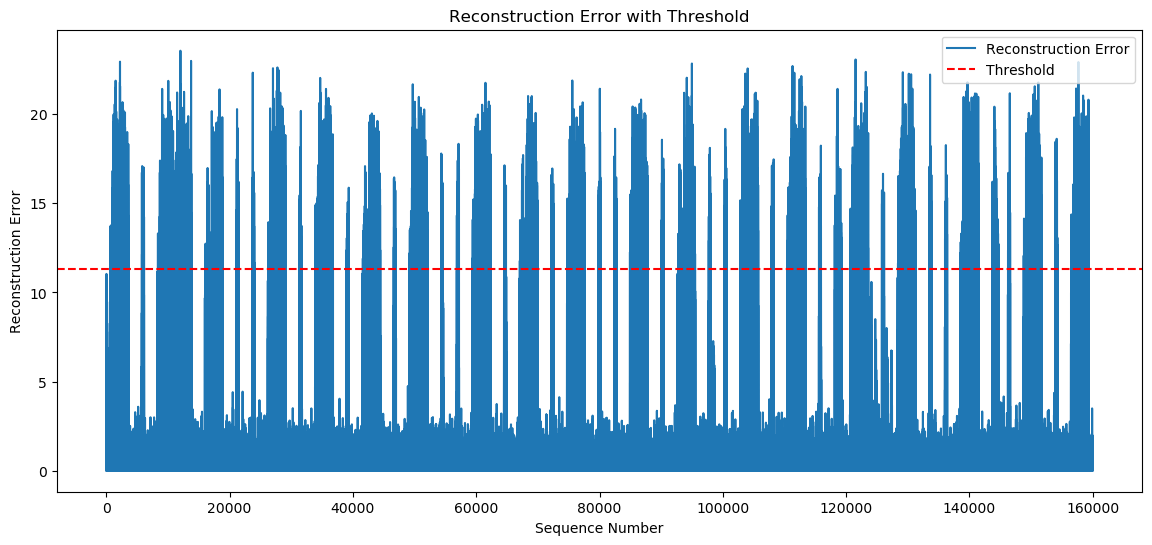

In [2]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


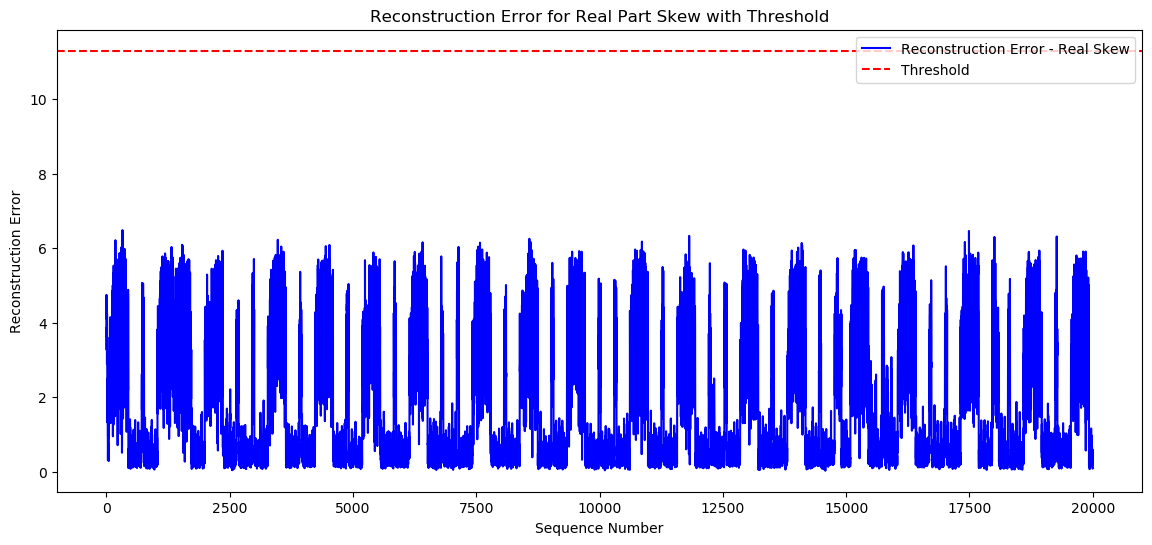

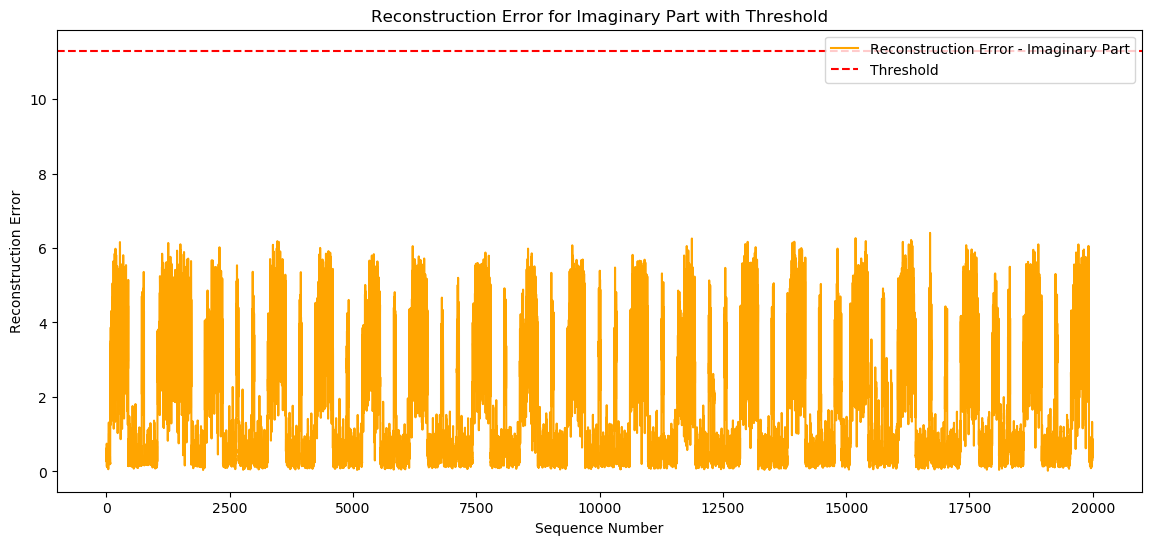

In [3]:
# reconstruction error
reconstruction_error_real_parts = reconstruction_error[:, 0]
reconstruction_error_real_std = reconstruction_error[:, 1]
reconstruction_error_real_skew = reconstruction_error[:, 2]
reconstruction_error_real_kurtosis = reconstruction_error[:, 3]
reconstruction_error_imag_parts = reconstruction_error[:, 4]
reconstruction_error_imag_std = reconstruction_error[:, 5]
reconstruction_error_imag_skew = reconstruction_error[:, 6]
reconstruction_error_imag_kurtosis = reconstruction_error[:, 7]

# Plot for Real Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_real_skew, label='Reconstruction Error - Real Skew', color='blue')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Real Part Skew with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('2-Reconstruction Error for Real Part with Threshold.png')
# plt.close()
plt.show()

# Plot for Imaginary Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_imag_skew, label='Reconstruction Error - Imaginary Part', color='orange')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Imaginary Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('3-Reconstruction Error for Imaginary Part with Threshold.png')
# plt.close()
plt.show()



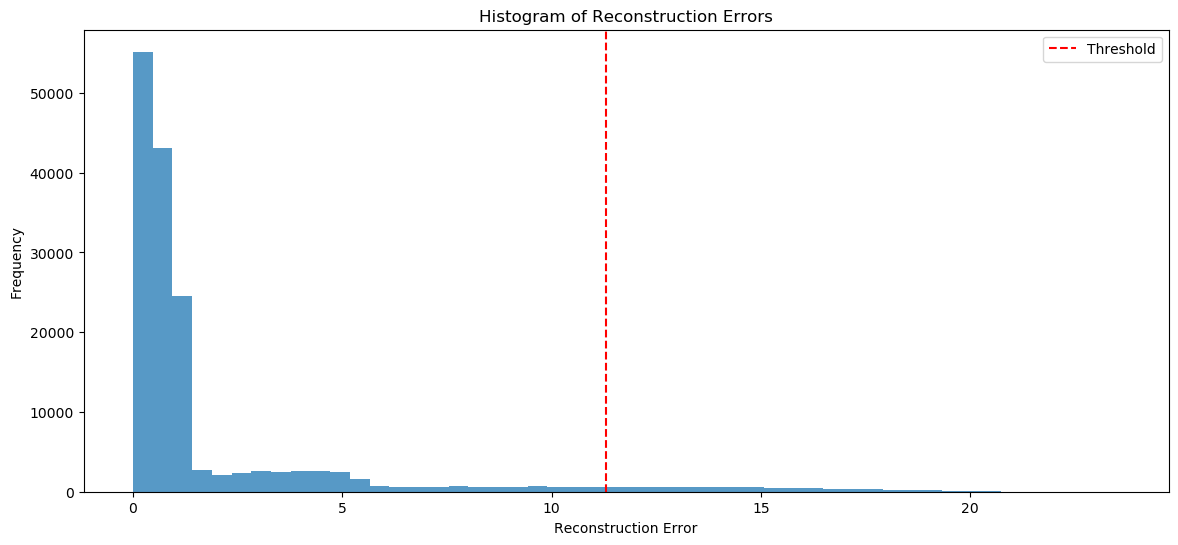

In [4]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

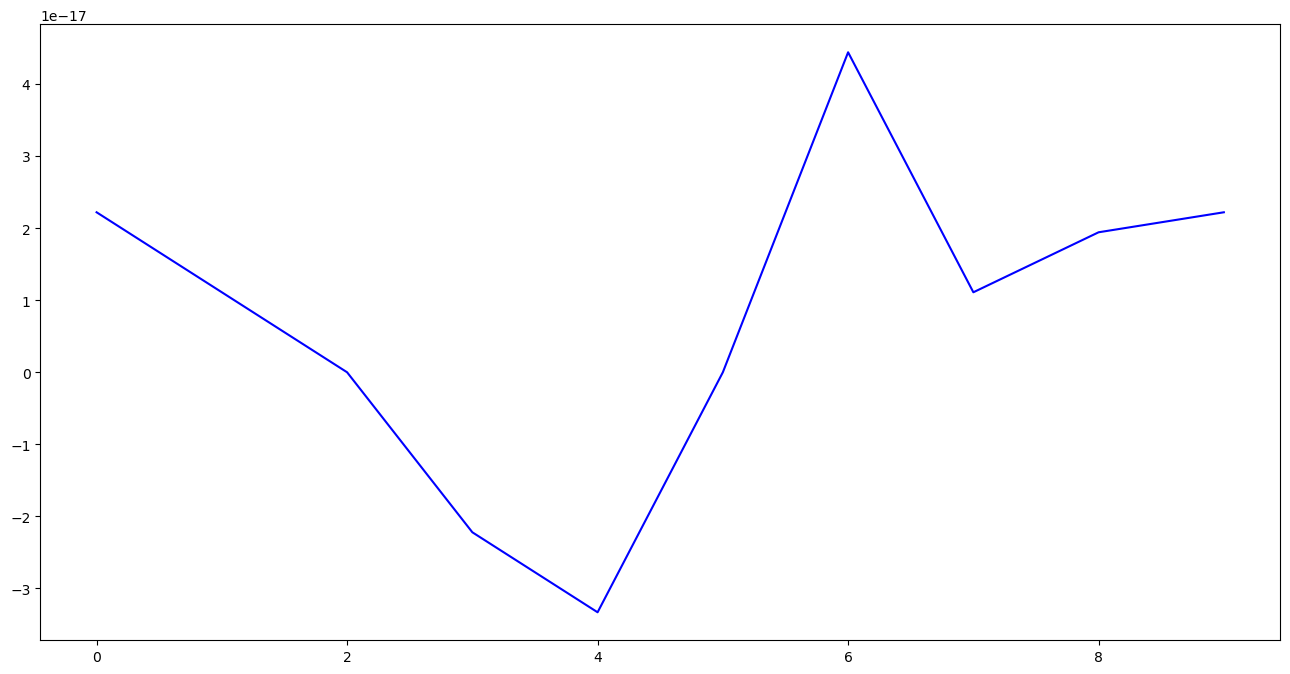

In [5]:
# real_parts, axis=1),
# np.std(real_parts, axis=1),
# skew(real_parts, axis=1),
# kurtosis(real_parts, axis=1),
# np.mean(imag_parts, axis=1),
# np.std(imag_parts, axis=1),
# skew(imag_parts, axis=1),
# kurtosis(imag_parts, axis=1)
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 4], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()


In [ ]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
# plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
# plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

# plt.plot(original_sample[:, 4], 'g-', label='Original Imaginary Part')
# plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [ ]:
# # Define the number of sequences to plot together
n = 2  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 4], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()


In [ ]:
# Repeat for n = 9
n = 8  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 2], 'b-', label='Original Real Part Skew')
plt.plot(reconstructed_sample[:, 2], 'r--', label='Reconstructed Real Part Skew')
plt.plot(original_sample[:, 6], 'g-', label='Original Imaginary Part Skew')
plt.plot(reconstructed_sample[:, 6], 'y--', label='Reconstructed Imaginary Part Skew')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()


In [ ]:
# Repeat for n = 9
n = 8  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 3], 'b-', label='Original Real Part Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'r--', label='Reconstructed Real Part Kurtosis')
plt.plot(original_sample[:, 7], 'g-', label='Original Imaginary Part Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'y--', label='Reconstructed Imaginary Part Kurtosis')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Plotting the time taken for each prediction
plt.plot(prediction_times)
plt.xlabel('Prediction Number')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken for Each Prediction')
plt.show()

In [ ]:
# Calculate cumulative average and minimum for each prediction step
cumulative_average = np.cumsum(prediction_times) / np.arange(1, len(prediction_times) + 1)
cumulative_minimum = np.minimum.accumulate(prediction_times)


# Plot for Average Prediction Time
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_average, label='Cumulative Average Time')
plt.xlabel('Prediction Number')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Prediction Time')
plt.legend()
plt.show()


In [ ]:
# Plot for Average Prediction Time
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_minimum, label='Cumulative Min')
plt.xlabel('Prediction Number')
plt.ylabel('Time Taken (seconds)')
plt.title('Min Prediction Time')
plt.legend()
plt.show()

In [ ]:
max_average_time = max(cumulative_average)

# Plot for Average Prediction Time with refined y-axis
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_average, label='Cumulative Average Time')
plt.xlabel('Prediction Number')
plt.ylabel('Max Time Taken (seconds)')
plt.title('Max Prediction Time')
plt.ylim(0, max_average_time)  # Set the y-axis to show from 0 to maximum average time
plt.legend()
plt.grid(True)  # Add grid for better precision viewing
plt.show()

In [ ]:
min_average_time = min(cumulative_average)
buffer = min_average_time * 0.2  # 10% of the minimum average time for buffer

# Plot for Average Prediction Time with refined y-axis around minimum
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_average, label='Cumulative Average Time')
plt.xlabel('Prediction Number')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Prediction Time')
plt.ylim(min_average_time - buffer, min_average_time + buffer)  # Zoom in on the min average time
plt.legend()
plt.grid(True)  # Add grid for better precision viewing
plt.show()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
